In [1]:
from NLP_functions import word_list_to_string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Embedding, SpatialDropout1D, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('data/train.tsv', sep='\t')

In [3]:
df = df.drop(columns=['eebbqej'])

In [4]:
df.columns = ['comment', 'emotions']

### Multilabel to Single Label ( 14, 27 ---> 14 )

In [5]:
single_cats = []
for multi_cats in df.emotions:
    single_cats.append(multi_cats.split(',')[0])

In [6]:
sing_cat_ser = pd.Series(single_cats)

In [7]:
df['emotion'] = sing_cat_ser

### Consolidate Categories

In [8]:
df = df.loc[df['emotion'].isin(['2', '4', '6', '7', '13', '14', '17', '18', '25', '26'])]

### CleanText

In [9]:
# Max words to be used. (most frequent)
max_words = 300000

# Max words in each comment.
max_seq_len = 500

embedding_dim = 100

In [10]:
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-.//:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['comment'].values)
word_index = tokenizer.word_index

In [11]:
X = tokenizer.texts_to_sequences(df['comment'].values)
X = pad_sequences(X, maxlen=max_seq_len)

In [12]:
y = pd.get_dummies(df['emotion']).values

### Train/Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

### RNN Model

In [14]:
model = keras.Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
epochs = 10
batch_size = 128

history = model.fit(X_train, y_train, epochs=epochs, 
                    batch_size=batch_size, 
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
71/71 [==============================] - 55s 753ms/step - loss: 2.2091 - accuracy: 0.2021 - val_loss: 2.1422 - val_accuracy: 0.2256
Epoch 2/10
71/71 [==============================] - 49s 694ms/step - loss: 1.9587 - accuracy: 0.3129 - val_loss: 1.7815 - val_accuracy: 0.3857
Epoch 3/10
71/71 [==============================] - 50s 702ms/step - loss: 1.5019 - accuracy: 0.5045 - val_loss: 1.5459 - val_accuracy: 0.4811
Epoch 4/10
71/71 [==============================] - 50s 706ms/step - loss: 1.1419 - accuracy: 0.6256 - val_loss: 1.5278 - val_accuracy: 0.5030
Epoch 5/10
71/71 [==============================] - 49s 696ms/step - loss: 0.8693 - accuracy: 0.7278 - val_loss: 1.4894 - val_accuracy: 0.5179
Epoch 6/10
71/71 [==============================] - 51s 712ms/step - loss: 0.6515 - accuracy: 0.7934 - val_loss: 1.5581 - val_accuracy: 0.5199
Epoch 7/10
71/71 [==============================] - 50s 709ms/step - loss: 0.4737 - accuracy: 0.8593 - val_loss: 1.6233 - val_accuracy: 0.5318

In [16]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

79/79 [==============================] - 3s 34ms/step - loss: 1.6730 - accuracy: 0.5304
Test set
  Loss: 1.673
  Accuracy: 0.530


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 500, 100)          30000000  
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 500, 100)          0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 64)                42240     
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 10)                650       
Total params: 30,042,890
Trainable params: 30,042,890
Non-trainable params: 0
_________________________________________________________________


### Accuracy and Loss Plots

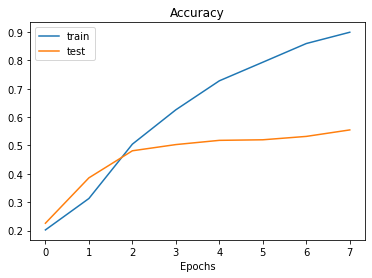

In [18]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.legend()
plt.show()

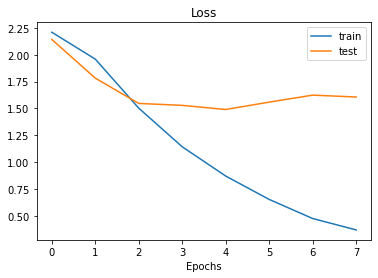

In [19]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.legend()
plt.show()